# Blockudoku solver

Helps finding the highest scoring play at a turn of Blockudoku

In [1]:
import sys
import random
import itertools
import importlib

import tqdm
import skimage

sys.path.append(".")
import arrays
import images
import game
importlib.reload(images)

<module 'images' from '/Users/axel/PycharmProjects/blockudoku-solver/images.py'>

First take a screenshot mid-game and airdrop it to your macbook

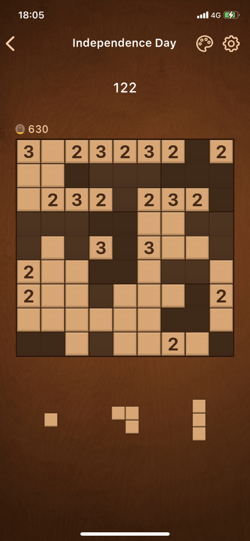

In [2]:
screenshot = images.latest_airdropped_screenshot()
images.display(screenshot)

Crop and apply 50% thresholding to binarize the game state:

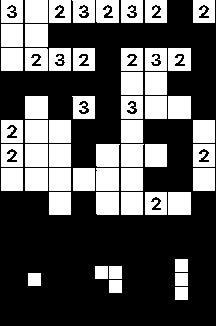

In [3]:
cropped_img = screenshot[420:1400, 50:-50]
binary_img = skimage.color.rgb2gray(cropped_img) > 0.5
images.display(binary_img)

Downsample the sudoku board to a 9x9 pixel grid:

In [4]:
board_img = binary_img[:binary_img.shape[1]]
board = skimage.transform.resize(board_img, (9, 9)).astype(int)
board

array([[0, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 1, 1, 0],
       [0, 1, 1, 0, 0, 1, 0, 0, 1],
       [0, 1, 1, 0, 1, 1, 1, 0, 1],
       [1, 1, 1, 1, 1, 1, 0, 0, 1],
       [0, 0, 1, 0, 1, 1, 1, 1, 0]])

Repeat with the three shapes below to obtain your hand:

In [5]:
def process_hand_shape(img):
    img = skimage.transform.resize(img, (20, 20))
    img = skimage.transform.resize(img, (5, 5))
    return arrays.trim_zeros(img).astype(int)

side = 220
hand_img = binary_img[730:730+side]
hand_0 = process_hand_shape(hand_img[:, :side])
hand_1 = process_hand_shape(hand_img[:, side:2*side])
hand_2 = process_hand_shape(hand_img[:, 2*side:3*side])
display(hand_0); print(); display(hand_1); print(); display(hand_2)

array([[1]])

array([[1, 1],
       [0, 1]])

array([[1],
       [1],
       [1]])

Compute all valid choices (coordinates) where each shape of the hand could be played.

In [6]:
coords_0 = game.legal_coords(hand_0, board)
coords_1 = game.legal_coords(hand_1, board)
coords_2 = game.legal_coords(hand_2, board)
choices = list(itertools.product(coords_0, coords_1, coords_2))

choices[:5]

[((0, 0), (0, 2), (0, 2)),
 ((0, 0), (0, 2), (0, 4)),
 ((0, 0), (0, 2), (0, 6)),
 ((0, 0), (0, 2), (0, 8)),
 ((0, 0), (0, 2), (1, 2))]

If there are too many options, sample an amount that can be completed reasonably fast.

In [7]:
N = len(choices)
print(N, "possible choices")
N_max = 100_000
if N > N_max:
    print(f"too many choices, subsampling {N_max:,} choices")
    choices = random.sample(choices, k=N_max)
    N = len(choices)

11776 possible choices


In [8]:
importlib.reload(game)
hand = [hand_0, hand_1, hand_2]
attempts = []

if N >= 5000:
    choices = tqdm.tqdm(choices)

#choices = [choice for choice in choices if choice[1][0] == 3 and choice[1][1] == 6]
#choices = [((1, 6), (3, 6), (5, 7))]
orders = list(itertools.permutations([0, 1, 2]))

for choice in choices:
    for order in orders:
        new_board = board.copy()
        attempt = { "score": 0, "anticipation_score": 0 }

        for index in order:
            i, j = choice[index]
            simple_score, score = game.play_shape(hand[index], new_board, i, j)
            attempt = {
                **attempt,
                "score": attempt["score"] + score,
                f"i{index}": i,
                f"j{index}": j,
                f"clears{index}": simple_score,
                "order": order,
            }
        
        if attempt["score"]:
            anticipation = game.anticipation_score(board)
            attempt["anticipation_score"] = anticipation
            #attempt["score"] += anticipation
            attempts.append(attempt)

if attempts:
    print(f"{len(attempts)}/{N*len(orders)} attempts with scores")
    display(game.display_best_plays(attempts, board, hand, display_max=3))
else:
    print("no scoring")


100%|███████████████████████████████████| 11776/11776 [00:04<00:00, 2626.34it/s]

1080/70656 attempts with scores


2       4
3       6
1    1070
Name: score, dtype: int64

,score,i0,j0,i1,j1,i2,j2,anticipation_score,clears0,order,clears2,clears1
0,3,8,1,3,1,3,0,0.0,0,"(2, 0, 1)",0,2


,0,1,2,3,4,5,6,7,8
0,,.,,,,,,,
1,.,.,,,,,,,
2,.,.,,.,,.,,.,
3,0,2,2,,,.,.,,
4,0,.,2,,,,.,.,
5,0,.,.,,,.,,,.
6,,.,.,,.,.,.,,.
7,.,.,.,.,.,.,,,.
8,,1,.,,.,.,.,.,


,score,i0,j0,i1,j1,i2,j2,anticipation_score,clears0,order,clears2,clears1
1,3,8,1,3,1,3,0,0.0,0,"(0, 2, 1)",0,2


,0,1,2,3,4,5,6,7,8
0,,.,,,,,,,
1,.,.,,,,,,,
2,.,.,,.,,.,,.,
3,1,2,2,,,.,.,,
4,1,.,2,,,,.,.,
5,1,.,.,,,.,,,.
6,,.,.,,.,.,.,,.
7,.,.,.,.,.,.,,,.
8,,0,.,,.,.,.,.,


,score,i0,j0,i1,j1,i2,j2,anticipation_score,clears0,order,clears2,clears1
2,3,0,0,3,1,0,2,0.0,0,"(0, 1, 2)",2,0


,0,1,2,3,4,5,6,7,8
0,0,.,2,,,,,,
1,.,.,2,,,,,,
2,.,.,2,.,,.,,.,
3,,1,1,,,.,.,,
4,,.,1,,,,.,.,
5,,.,.,,,.,,,.
6,,.,.,,.,.,.,,.
7,.,.,.,.,.,.,,,.
8,,,.,,.,.,.,.,


None

In [9]:
import pandas as pd
pd.DataFrame(attempts).drop_duplicates().sort_values("anticipation_score", ascending=False).reset_index(drop=True)

,score,anticipation_score,i0,j0,clears0,order,i2,j2,clears2,i1,j1,clears1
0,1,0.0,0,0,0,"(0, 2, 1)",0,2,1,0,2,0
1,1,0.0,6,7,0,"(2, 1, 0)",0,2,0,3,1,1
2,1,0.0,6,3,0,"(1, 2, 0)",3,0,1,3,1,0
3,1,0.0,6,3,0,"(2, 0, 1)",3,0,0,3,1,1
4,1,0.0,6,3,0,"(2, 1, 0)",3,0,0,3,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1075,1,0.0,3,2,0,"(2, 1, 0)",0,2,0,3,1,1
1076,1,0.0,3,2,0,"(1, 0, 2)",3,0,1,3,1,0
1077,1,0.0,3,2,0,"(1, 2, 0)",3,0,1,3,1,0
1078,1,0.0,3,2,0,"(2, 1, 0)",3,0,0,3,1,1
